## Minimax Implementation

In [13]:
def evaluate_board(game, board):
    red_score = 0
    white_score = 0

    # Set the values for normal pieces and kings
    piece_value = 10  # Normal piece value
    king_value = 12  # King piece value
    capture_bonus = 8  # Additional points for each capture

    # Counting the pieces
    for row in board:
        for piece in row:
            if piece is not None:
                base_value = king_value if piece.king else piece_value
                if piece.color == RED:
                    red_score += base_value
                elif piece.color == WHITE:
                    white_score += base_value

    # Adding capture bonus based to the difference of pieces from the start
    initial_pieces = 12  # Starting number of pieces per player in a standard checkers game
    red_captures = initial_pieces - sum(1 for row in board for piece in row if piece and piece.color == WHITE)
    white_captures = initial_pieces - sum(1 for row in board for piece in row if piece and piece.color == RED)

    red_score += red_captures * capture_bonus
    white_score += white_captures * capture_bonus

    # Calculating the score from the perspective of the player whose turn it is
    if game.turn == RED:
        return red_score - white_score
    else:
        return white_score - red_score


def get_all_moves(board, color):
    moves = []
    # Going through every row and column
    for row in range(ROWS):
        for col in range(COLS):
            piece = board.get_piece(row, col)
            # Getting valid moves for every piece of the right color according to the turn
            if piece is not None and piece.color == color:
                valid_moves = board.get_valid_moves(piece)
                # Recording a potential move
                for move, skip in valid_moves.items():
                    moves.append((deepcopy(piece), move, skip, piece))
    return moves
def minimax(position, depth, alpha, beta, maximizing_player):    
    # Checking for the termination condition
    if depth == 0 or position.winner() is not None:
        return evaluate_board(position, position.board.board), None
    
    if maximizing_player:
        max_eval = float('-inf')
        best_move = None
        # Going through every possible move for maximizing player
        for move in get_all_moves(position.board, WHITE if position.turn == WHITE else RED):
            new_game = position.copy_without_surface()
            # Applying the move to the game
            new_game.move(move[0], move[1][0], move[1][1], change_turn=False)
            # Recording the minimax evaluation of the move
            evaluation = minimax(new_game, depth-1, alpha, beta, False)[0]
            
            # If the move's score is greater than the current max, we set it to best move
            if evaluation > max_eval:
                max_eval = evaluation
                best_move = move
            alpha = max(alpha, evaluation)
            
            # Pruning for maximizing player
            # The opponent would avoid these branches
            if beta <= alpha:
                break
        return max_eval, best_move
    
    else:
        min_eval = float('inf')
        best_move = None
        # Going through every possible move for the minimizing player
        for move in get_all_moves(position.board, RED if position.turn == WHITE else WHITE):
            new_game = position.copy_without_surface()
            # Applying the move to the board
            new_game.move(move[0], move[1][0], move[1][1], change_turn=False)
            # Calculating the move's score
            evaluation = minimax(new_game, depth-1, alpha, beta, True)[0]
            
            # Pruning step for the minimizing player
            # The opponent would avoid this branch
            if evaluation < min_eval:
                min_eval = evaluation
                best_move = move    
            beta = min(beta, evaluation)
            if beta <= alpha:
                break
        return min_eval, best_move

## Checkers implementation and main run function

Red starts the game!


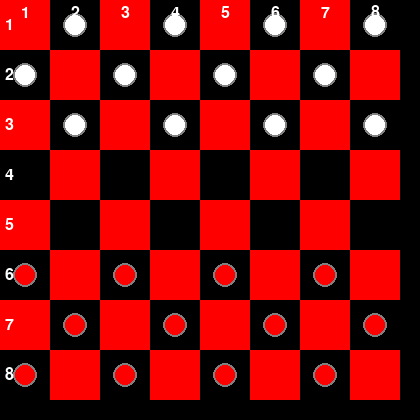

KeyboardInterrupt: Interrupted by user

In [14]:
import pygame
from copy import deepcopy
import io
from PIL import Image
import IPython.display as display
import numpy as np

# Initialize Pygame
pygame.init()

# Constants
WIDTH, HEIGHT = 400, 400  # Smaller board size
ROWS, COLS = 8, 8
SQUARE_SIZE = WIDTH // COLS
LABEL_PADDING = 20  # Space for labels

WINDOW_WIDTH = WIDTH + LABEL_PADDING
WINDOW_HEIGHT = HEIGHT + LABEL_PADDING

# Colors
RED = (255, 0, 0)
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
BLUE = (0, 0, 255)
GREY = (128, 128, 128)

# Function to display Pygame Surface
def show_surface(surface):
    data = pygame.image.tostring(surface, 'RGB')
    image = Image.frombytes('RGB', surface.get_size(), data)
    io_buf = io.BytesIO()
    image.save(io_buf, format='png')
    io_buf.seek(0)
    display.display(display.Image(data=io_buf.getvalue()))
    
def draw_labels(win):
    font = pygame.font.Font(None, 24)  # Using a default font and size
    for row in range(ROWS):
        # Draw row labels on the left
        text = font.render(str(row + 1), True, WHITE)
        win.blit(text, (5, row * SQUARE_SIZE + SQUARE_SIZE // 2 - text.get_height() // 2))
    for col in range(COLS):
        # Draw column labels on the top
        text = font.render(str(col + 1), True, WHITE)
        win.blit(text, (col * SQUARE_SIZE + SQUARE_SIZE // 2 - text.get_width() // 2, 5))

class Piece:
    PADDING = 15
    OUTLINE = 2

    def __init__(self, row, col, color):
        self.row = row
        self.col = col
        self.color = color
        self.king = False
        self.x = 0
        self.y = 0
        self.calc_pos()

    def calc_pos(self):
        self.x = SQUARE_SIZE * self.col + SQUARE_SIZE // 2
        self.y = SQUARE_SIZE * self.row + SQUARE_SIZE // 2

    def make_king(self):
        self.king = True

    def draw(self, win):
        radius = SQUARE_SIZE//2 - self.PADDING
        pygame.draw.circle(win, GREY, (self.x, self.y), radius + self.OUTLINE)
        pygame.draw.circle(win, self.color, (self.x, self.y), radius)
        if self.king:
            # Example: Draw a simple crown symbol on the king
            pygame.draw.circle(win, BLUE, (self.x, self.y - 15), 10)  # Crown representation
    
    def is_king_row(self):
        if self.color == RED:
            return self.row == 0
        else:
            return self.row == 7
    
    def is_valid_move(self, start_row, start_col, end_row, end_col, board):
        # Checking if the move is within the board's bounds
        if end_row < 0 or end_row >= ROWS or end_col < 0 or end_col >= COLS:
            return False
        # Checking if the destination square is empty
        if board[end_row][end_col] is not None:
            return False
        # Checking if the movement is diagonal
        if abs(end_row - start_row) != abs(end_col - start_col):
            return False
        # Checking for forward movement according to piece color
        if self.king:
            # Kings move both directions
            return abs(start_row - end_row) in [1, 2] and abs(start_col - end_col) in [1, 2]
        else:
            # Checking for forward movement according to the color
            direction = -1 if self.color == RED else 1
            return ((end_row - start_row) == direction * 1 or (end_row - start_row) == direction * 2) and abs(start_col - end_col) in [1, 2]
    
    def move(self, board_instance, row, col):
        jumped = None
        # If the movement is 2 squares in any direction, it's a jump
        if abs(row - self.row) == 2 and abs(col - self.col) == 2:
            jumped = ((self.row + row) // 2, (self.col + col) // 2)
        board_instance.board[self.row][self.col] = None
        # Updating the piece's location
        self.row = row
        self.col = col
        self.calc_pos()
        board_instance.board[row][col] = self 
        return jumped if jumped else (None, None)

class Board:
    def __init__(self):
        self.board = []
        self.create_board()
    
    def draw_squares(self, win):
        win.fill(BLACK)
        for row in range(ROWS):
            for col in range(row % 2, COLS, 2):
                pygame.draw.rect(win, RED, (row * SQUARE_SIZE, col * SQUARE_SIZE, SQUARE_SIZE, SQUARE_SIZE))

    def create_board(self):
        for row in range(ROWS):
            self.board.append([])
            for col in range(COLS):
                if col % 2 == ((row + 1) % 2):
                    if row < 3:
                        self.board[row].append(Piece(row, col, WHITE))
                    elif row > 4:
                        self.board[row].append(Piece(row, col, RED))
                    else:
                        self.board[row].append(None)
                else:
                    self.board[row].append(None)

    def draw(self, win):
        self.draw_squares(win)
        for row in range(ROWS):
            for col in range(COLS):
                piece = self.get_piece(row, col)
                if piece:
                    piece.draw(win)

    def get_piece(self, row, col):
        return self.board[row][col]
        
    def get_valid_moves(self, piece):
        # The diagonale directions of where the pieces can move to based on color and king status
        if piece.king:
            directions = [(-1, -1), (-1, 1), (1, -1), (1, 1)]  # Kings can move in all four diagonal directions
        elif piece.color == WHITE:
            directions = [(1, -1), (1, 1)]  # Downward directions for white
        else:
            directions = [(-1, -1), (-1, 1)]  # Upward directions for red
        moves = {}
        
        # Going through every possible move
        for d_row, d_col in directions:
            cur_row, cur_col = piece.row + d_row, piece.col + d_col

            # Single step move
            # Checking if the move is within bounds and next square is empty
            if self.is_within_bounds(cur_row, cur_col) and self.get_piece(cur_row, cur_col) is None:
                moves[(cur_row, cur_col)] = [] # no captures of the potential move

            # Checking for possible captures
            # Jump is 2 single moves
            jump_row, jump_col = cur_row + d_row, cur_col + d_col
            if self.is_within_bounds(jump_row, jump_col) and self.get_piece(jump_row, jump_col) is None:
                # The captured piece is in the middle of the jump
                jumped_piece = self.get_piece(cur_row, cur_col)
                # Recording the captured piece of the opposite color
                if jumped_piece and jumped_piece.color != piece.color:
                    moves[(jump_row, jump_col)] = [jumped_piece]

        return moves
    
    def is_within_bounds(self, row, col):
        return 0 <= row < ROWS and 0 <= col < COLS

class Game:
    def __init__(self, win):
        self.win = win 
        self.board = Board()
        self.turn = RED # red starts
        
    def copy_without_surface(self):
        new_game = Game(None) 
        # Perform the actual deep copy without the surface
        new_game.board = deepcopy(self.board)
        new_game.turn = self.turn
        return new_game

    def update(self):
        self.win.fill(BLACK)
        self.board.draw(self.win)
        draw_labels(self.win) 
        
    def move(self, piece, row, col, change_turn=True):
        # Checking if the move is valid
        if piece.is_valid_move(piece.row, piece.col, row, col, self.board.board):
            # Moving the piece, updating the piece's location
            # Checking for a jump and deleting the captured piece
            jumped_row, jumped_col = piece.move(self.board, row, col)
            if jumped_row:
                self.board.board[jumped_row][jumped_col] = None
            if piece.is_king_row():
                piece.make_king()
            # If waitig for the user's input
            if change_turn:
                self.change_turn()
        else:
            print("Invalid move")

    def select(self, row, col):
        piece = self.board.get_piece(row, col)
        if piece is None:
            return False, "No piece at this position."
        if piece.color != self.turn:
            return False, f"Wrong piece! You are playing {'RED' if self.turn == RED else 'WHITE'} now!"
        return True, ""

    def change_turn(self):
        if self.turn == WHITE:
            self.turn = RED
        else: 
            self.turn = WHITE
    
    def winner(self):
        # Initializig counters for each player's pieces
        red_pieces = 0
        white_pieces = 0
        
        # Iterating over all squares on the board to count pieces for each player
        for row in self.board.board:
            for piece in row:
                if piece is not None:
                    # Counting red pieces
                    if piece.color == RED:
                        red_pieces += 1
                    # Counting white pieces
                    elif piece.color == WHITE:
                        white_pieces += 1
        
        # If one player has no pieces left, the other player wins
        if red_pieces == 0 and white_pieces > 0:
            return WHITE  # White is the winner
        elif white_pieces == 0 and red_pieces > 0:
            return RED  # Red is the winner
        
        # If neither player can make a move, the game is a draw (you could also return a draw result)
        red_moves = get_all_moves(self.board, RED)
        white_moves = get_all_moves(self.board, WHITE)
        if red_moves == [] and white_moves == []:
            return "DRAW"
        elif red_moves == [] and white_moves != []:
            return WHITE
        elif red_moves != [] and white_moves == []:
            return RED
        
        # No winner yet
        return None


def run_game(ai_playing=True, ai_color=WHITE):
    win = pygame.Surface((WINDOW_WIDTH, WINDOW_HEIGHT))
    game = Game(win)
    print("Red starts the game!")
    game.update()
    show_surface(win)

    continue_game = True
    while continue_game:
        # If playing with AI and it is AI's turn
        if game.turn == ai_color and ai_playing:
            print(f"AI ({'White' if ai_color == WHITE else 'Red'}) is thinking...")
            # Getting all possible moves for AI
            possible_moves = get_all_moves(game.board, game.turn)
            # If there are no moves, AI lost
            if not possible_moves:
                print(f"No possible moves, {game.winner()} wins!")
                break
                
            _, chosen_move = minimax(game, 5, float('-inf'), float('inf'), True)  # Depth is set to 5
            
            if chosen_move:
                _, move_to, _, piece = chosen_move
            else:
                chosen_move = possible_moves[0]
                _, move_to, _, piece = chosen_move
            
            # Moving the checker piece to the chosen square
            game.move(piece, move_to[0], move_to[1])
            game.update()
            show_surface(win)
        
        # If it is not AI's turn, it is the user's turn
        elif not ai_playing or game.turn != ai_color:
            try:
                row, col = map(int, input("Enter move from row,col: ").split(','))
                valid, message = game.select(row - 1, col - 1) # validating color
                if not valid:
                    print(message)
                    continue
                
                new_row, new_col = map(int, input("Enter move to row,col: ").split(','))
                piece = game.board.get_piece(row - 1, col - 1)
                # Moving the checker piece to the new square
                game.move(piece, new_row - 1, new_col - 1)
                game.update()
                show_surface(win)
            except Exception as e:
                print(f"Error: {str(e)}")
                continue

        # Checking for a winner
        if game.winner():
            if game.winner() == (255, 255, 255):
                print("WHITE (AI) wins!")
            elif game.winner() == (255, 0, 0):
                print("RED (human) wins!")
            break

        if input("Continue playing? (y/n): ").lower() == 'n':
            continue_game = False

run_game()